<a href="https://colab.research.google.com/github/amsem/citrus-leaves-disease-classification/blob/main/InceptionResNetV2_Based_Leaf_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the drive module from google.colab to access Google Drive.
from google.colab import drive

# Mounting Google Drive to the /content/drive directory. This will prompt the user to authenticate and grant access.
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Using the cp command to copy the zip file named Leaves-20240618T015705Z-001.zip from the Google Drive location
# (drive/MyDrive/) to the current working directory (./) in the Colab environment.
!cp -r drive/MyDrive/Leaves-20240618T015705Z-001.zip ./

In [ ]:
!unzip Leaves-20240618T015705Z-001.zip

Archive:  Leaves-20240618T015705Z-001.zip
  inflating: Leaves/Melanose/SAM_3927Catla.jpg  
  inflating: Leaves/canker/17.pn.png  
  inflating: Leaves/Melanose/SAM_3928Catla.jpg  
  inflating: Leaves/Melanose/SAM_3937Catla.jpg  
  inflating: Leaves/Melanose/SAM_4840Catla.jpg  
  inflating: Leaves/Melanose/SAM_3938Catla.jpg  
  inflating: Leaves/Melanose/146.jpg  
  inflating: Leaves/Melanose/SAM_3941Catla.jpg  
  inflating: Leaves/Melanose/SAM_3929Catla.jpg  
  inflating: Leaves/Melanose/34.jpg  
  inflating: Leaves/canker/19.pn.png  
  inflating: Leaves/canker/21.pn.png  
  inflating: Leaves/Melanose/33.jpg  
  inflating: Leaves/greening/g (112).png  
  inflating: Leaves/canker/163.p.png  
  inflating: Leaves/canker/18.pn.png  
  inflating: Leaves/canker/26.pn.png  
  inflating: Leaves/Melanose/38.jpg  
  inflating: Leaves/canker/2.png.png  
  inflating: Leaves/canker/23.pn.png  
  inflating: Leaves/greening/g (109).png  
  inflating: Leaves/canker/159.p.png  
  inflating: Leaves/canke

In [ ]:
!rm -rf Leaves/Melanose/

In [ ]:
# Importing necessary libraries for data manipulation, visualization, and deep learning.

# Importing numpy for numerical computations.
import numpy as np

# Importing pandas for data manipulation and analysis.
import pandas as pd

# Importing matplotlib for data visualization.
import matplotlib.pyplot as plt

# Importing modules from TensorFlow and Keras for building and training neural network models.
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization, Input, MaxPooling2D, GlobalMaxPooling2D, concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.applications import densenet, inception_resnet_v2

# Importing ImageDataGenerator from keras for data augmentation and preprocessing.
from keras.preprocessing.image import ImageDataGenerator

# Importing modules from sklearn for evaluating the performance of the model.
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc

# Importing seaborn for advanced data visualization.
import seaborn as sns


In [ ]:
# Creating an instance of ImageDataGenerator for data augmentation and preprocessing.

data_gen = ImageDataGenerator(
    horizontal_flip=True,      # Randomly flip inputs horizontally.
    vertical_flip=True,        # Randomly flip inputs vertically.
    rotation_range=360,        # Randomly rotate images in the range 0-360 degrees.
    width_shift_range=0.2,     # Randomly shift images horizontally by 20% of the width.
    height_shift_range=0.2,    # Randomly shift images vertically by 20% of the height.
    zoom_range=0.1,            # Randomly zoom into images by up to 10%.
    rescale=1/255,             # Rescale pixel values to be between 0 and 1.
    fill_mode='nearest',       # Fill in new pixels created after a transform with the nearest pixel values.
    shear_range=0.1,           # Apply shear transformation with a shear intensity (shear angle in counter-clockwise direction in degrees) of 0.1.
    brightness_range=[0.5, 1.5], # Randomly change the brightness of images between 50% (dark) and 150% (bright).
    validation_split=0.3       # Set aside 30% of the data for validation.
)


In [ ]:
# Defining the shape of the input images. In this case, the images will be 299x299 pixels.
img_shape = 299

# Defining the batch size for the data generator. This is the number of images to be processed in one batch.
batch_size = 24


In [ ]:
# Loading the training data using the ImageDataGenerator instance (data_gen).
# The data is loaded from the 'Leaves' directory.

leaves_train_generator = data_gen.flow_from_directory(
    'Leaves',                    # Path to the directory containing the images.
    target_size=(img_shape, img_shape), # Resizing the images to the specified shape (299x299 pixels).
    batch_size=batch_size,       # Number of images to be processed in one batch (24).
    class_mode='categorical',    # Specifies that the labels are categorical (one-hot encoded).
    subset='training',           # Specifies that this is the training subset.
    shuffle=True                 # Shuffling the data for better training performance.
)


Found 2128 images belonging to 7 classes.


In [ ]:
# Setting a variable to indicate whether to shuffle the validation data or not.
val_suffle = False

# Loading the validation data using the ImageDataGenerator instance (data_gen).
# The data is loaded from the 'Leaves' directory.

leaves_val_generator = data_gen.flow_from_directory(
    'Leaves',                    # Path to the directory containing the images.
    target_size=(img_shape, img_shape), # Resizing the images to the specified shape (299x299 pixels).
    batch_size=batch_size,       # Number of images to be processed in one batch (24).
    class_mode='categorical',    # Specifies that the labels are categorical (one-hot encoded).
    subset='validation',         # Specifies that this is the validation subset.
    shuffle=val_suffle           # Indicates whether to shuffle the validation data (False in this case).
)



Found 906 images belonging to 7 classes.


In [ ]:
# Getting the next batch of images and labels from the training data generator.

# leaves_train_generator.next() returns a tuple where:
# - The first element (index 0) is a batch of images.
# - The second element (index 1) is the corresponding batch of labels.

# Printing the shapes of the images and labels in the next batch.
leaves_train_generator.next()[0].shape, leaves_train_generator.next()[1].shape


((24, 299, 299, 3), (24, 7))

In [ ]:
# Getting the next batch of images and labels from the validation data generator.

# leaves_val_generator.next() returns a tuple where:
# - The first element (index 0) is a batch of images.
# - The second element (index 1) is the corresponding batch of labels.

# Printing the shapes of the images and labels in the next batch.
leaves_val_generator.next()[0].shape, leaves_val_generator.next()[1].shape


((24, 299, 299, 3), (24, 7))

In [ ]:
# Creating an instance of the InceptionResNetV2 model from TensorFlow Keras applications.
# The model is initialized with pre-trained weights from ImageNet.

leaves_model = inception_resnet_v2.InceptionResNetV2(
    weights='imagenet',         # Loading weights pre-trained on the ImageNet dataset.
    include_top=False,          # Excluding the top (fully connected) layers of the model.
    input_shape=(img_shape, img_shape, 3)  # Setting the input shape to (299, 299, 3) to match the image shape.
)


219055592/219055592 [==============================] - 10s 0us/step


In [ ]:
# Fine-tuning the InceptionResNetV2 model by adding custom layers on top of the pre-trained base model.

# Getting the output from the base InceptionResNetV2 model.
x = leaves_model.output

# Adding a Global Average Pooling layer to reduce the spatial dimensions of the feature maps.
x = GlobalAveragePooling2D()(x)

# Adding a Dropout layer with a dropout rate of 0.3 to prevent overfitting.
x = Dropout(0.3)(x)

# Adding a Dense layer with 128 units and ReLU activation function.
x = Dense(128, activation="relu")(x)

# Adding another Dropout layer with a dropout rate of 0.3 to prevent overfitting.
x = Dropout(0.3)(x)

# Adding another Dense layer with 64 units and ReLU activation function.
x = Dense(64, activation="relu")(x)

# Adding the final Dense layer with 7 units (number of classes) and softmax activation function for classification.
predictions = Dense(7, activation="softmax")(x)


In [ ]:
# Creating the final model by combining the InceptionResNetV2 base model with the custom top layers.

# The inputs to the model are the inputs of the InceptionResNetV2 base model.
# The outputs of the model are the predictions from the custom top layers.

leaves_model = Model(inputs=leaves_model.input, outputs=predictions)


In [ ]:
# Defining a custom loss function for the model.

def custom_loss(y_true, y_pred):
    # Using categorical crossentropy as the loss function.
    # Adding label smoothing with a factor of 0.1 to make the model less confident on the training data,
    # which can help with generalization.
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)


In [ ]:
# Compiling the model with the specified optimizer, loss function, and evaluation metrics.

leaves_model.compile(
    optimizer='adam',                   # Using the Adam optimizer for training the model.
    loss=custom_loss,                   # Using the custom loss function defined earlier.
    metrics=['categorical_accuracy']    # Evaluating the model using categorical accuracy.
)


In [ ]:
leaves_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [ ]:
# Calculating the number of trainable and non-trainable parameters in the model.

# Summing the number of parameters in all trainable weights.
trainable_count = np.sum([K.count_params(w) for w in leaves_model.trainable_weights])

# Summing the number of parameters in all non-trainable weights.
non_trainable_count = np.sum([K.count_params(w) for w in leaves_model.non_trainable_weights])

# Printing the total number of parameters, trainable parameters, and non-trainable parameters.
print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))


Total params: 54,542,183
Trainable params: 54,481,639
Non-trainable params: 60,544


In [ ]:
# Training the model using the training data generator, and validating it using the validation data generator.

results = leaves_model.fit(
    leaves_train_generator,                          # Training data generator.
    epochs=15,                                       # Number of epochs to train the model.
    steps_per_epoch=leaves_train_generator.n / batch_size,  # Number of steps per epoch (total training samples / batch size).
    validation_data=leaves_val_generator,            # Validation data generator.
    validation_steps=leaves_val_generator.n / batch_size,  # Number of validation steps (total validation samples / batch size).
    callbacks=[                                      # List of callbacks to apply during training.
        ReduceLROnPlateau(                           # Reducing learning rate when a metric has stopped improving.
            monitor='val_loss',                      # Metric to monitor for learning rate reduction.
            factor=0.3,                              # Factor by which the learning rate will be reduced.
            patience=2,                              # Number of epochs with no improvement after which learning rate will be reduced.
            min_lr=0.000001                          # Lower bound on the learning rate.
        )
    ]
)


Epoch 1/15
88/88 [==============================] - 237s 2s/step - loss: 0.8793 - categorical_accuracy: 0.8214 - val_loss: 3.7480 - val_categorical_accuracy: 0.3245 - lr: 0.0010
Epoch 2/15
88/88 [==============================] - 137s 2s/step - loss: 0.6781 - categorical_accuracy: 0.8999 - val_loss: 1.2914 - val_categorical_accuracy: 0.6876 - lr: 0.0010
Epoch 3/15
88/88 [==============================] - 135s 2s/step - loss: 0.6411 - categorical_accuracy: 0.9272 - val_loss: 1.2495 - val_categorical_accuracy: 0.8565 - lr: 0.0010
Epoch 4/15
88/88 [==============================] - 133s 2s/step - loss: 0.6121 - categorical_accuracy: 0.9398 - val_loss: 0.8577 - val_categorical_accuracy: 0.8477 - lr: 0.0010
Epoch 5/15
88/88 [==============================] - 134s 2s/step - loss: 0.6114 - categorical_accuracy: 0.9474 - val_loss: 0.9350 - val_categorical_accuracy: 0.8212 - lr: 0.0010
Epoch 6/15
88/88 [==============================] - 138s 2s/step - loss: 0.5692 - categorical_accuracy: 0.9638

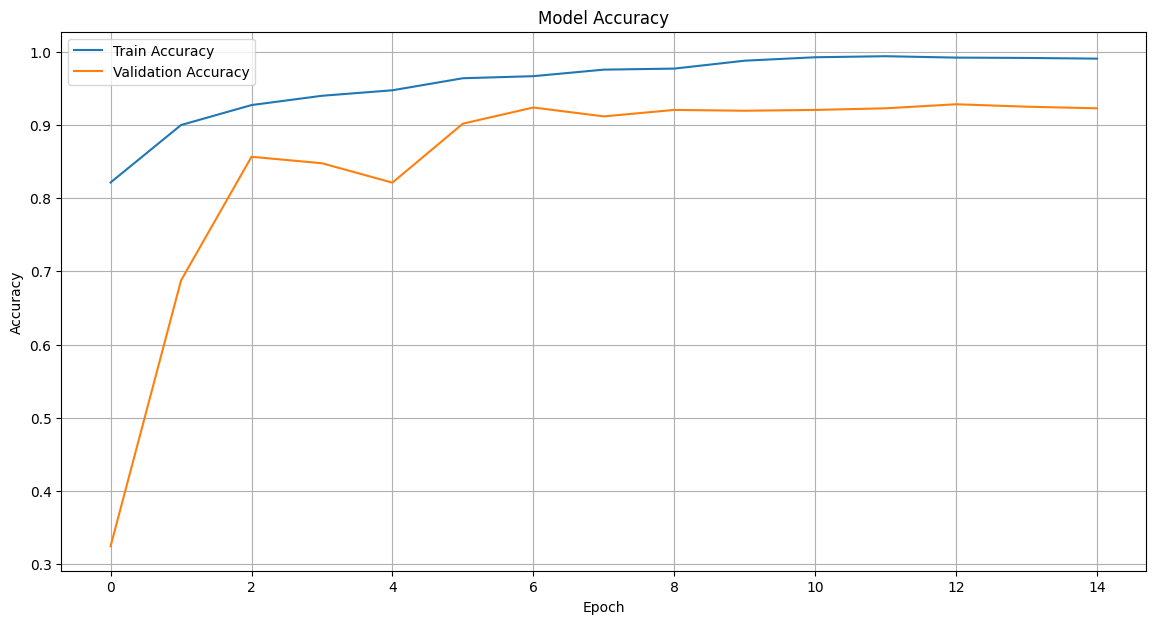

In [ ]:
# Plotting the accuracy graph for the training and validation accuracy over epochs.

plt.figure(figsize=(14, 7))  # Setting the figure size.

# Plotting the training accuracy from the results history.
plt.plot(results.history['categorical_accuracy'], label='Train Accuracy')

# Plotting the validation accuracy from the results history.
plt.plot(results.history['val_categorical_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')   # Setting the title of the plot.
plt.ylabel('Accuracy')        # Setting the label for the y-axis.
plt.xlabel('Epoch')           # Setting the label for the x-axis.
plt.legend(loc='upper left')  # Adding a legend to the plot in the upper left corner.
plt.grid(True)                # Adding a grid to the plot.
plt.show()                    # Displaying the plot.


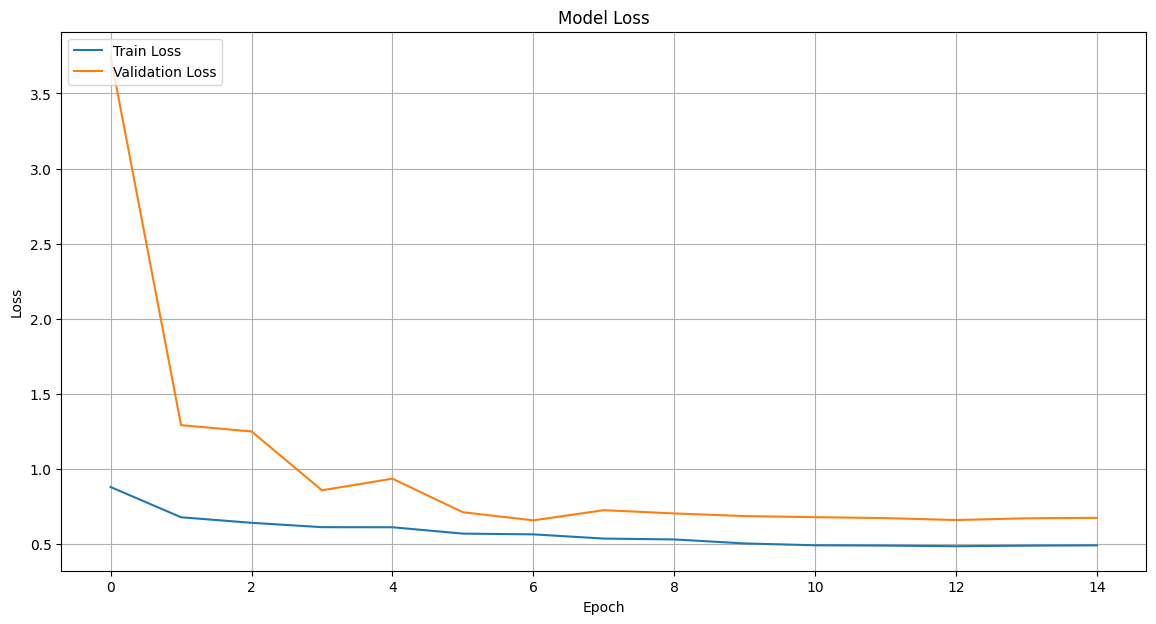

In [ ]:
# Plotting the loss graph for the training and validation loss over epochs.

plt.figure(figsize=(14, 7))  # Setting the figure size.

# Plotting the training loss from the results history.
plt.plot(results.history['loss'], label='Train Loss')

# Plotting the validation loss from the results history.
plt.plot(results.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')   # Setting the title of the plot.
plt.ylabel('Loss')        # Setting the label for the y-axis.
plt.xlabel('Epoch')       # Setting the label for the x-axis.
plt.legend(loc='upper left')  # Adding a legend to the plot in the upper left corner.
plt.grid(True)            # Adding a grid to the plot.
plt.show()                # Displaying the plot.


In [ ]:
# Evaluating the model on the validation data and getting predictions.

# Evaluating the model using the validation data generator.
leaves_model.evaluate(leaves_val_generator, steps=leaves_val_generator.n // batch_size)

# Resetting the validation data generator.
leaves_val_generator.reset()

# Evaluating the model again to ensure consistency.
leaves_model.evaluate(leaves_val_generator, steps=leaves_val_generator.n // batch_size)

# Resetting the validation data generator again.
leaves_val_generator.reset()

# Predicting the labels for the validation data.
y_pred = leaves_model.predict(leaves_val_generator, steps=leaves_val_generator.n / batch_size, verbose=1)

# If validation data was shuffled, apply the same shuffling to the true labels.
if val_suffle == True:
    per = np.random.permutation(leaves_val_generator.n)  # Creating a random permutation of indices.
    leaves_val_generator.index_array = per  # Applying the permutation to the generator's index array.
    y_true = leaves_val_generator.classes[per]  # Shuffling the true labels accordingly.
else:
    y_true = leaves_val_generator.classes  # Using the true labels as they are.

# Converting the predicted probabilities to class labels.
y_pred = np.argmax(y_pred, axis=1)

# Printing the shapes of the predicted and true labels.
y_pred.shape, y_true.shape


37/37 [==============================] - 44s 1s/step


((906,), (906,))

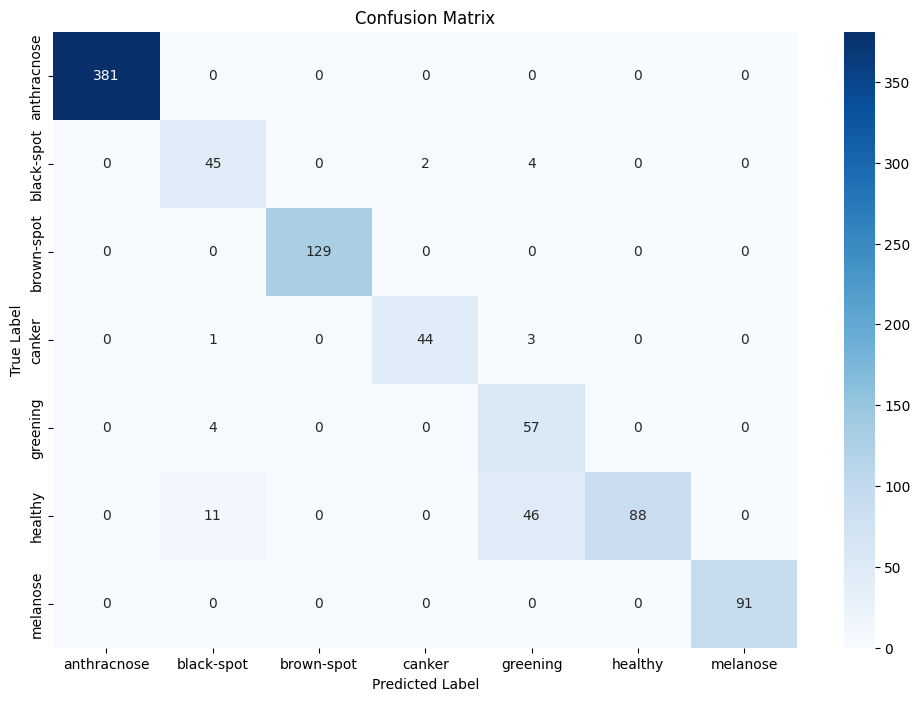

In [ ]:
# Generating and visualizing the confusion matrix.

# Creating the confusion matrix using the true and predicted labels.
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))  # Setting the figure size.

# Plotting the confusion matrix as a heatmap.
sns.heatmap(
    conf_matrix,                  # The confusion matrix to plot.
    annot=True,                   # Annotating each cell with the numeric value.
    fmt="d",                      # Formatting the annotation as integers.
    cmap="Blues",                 # Setting the color map to 'Blues'.
    xticklabels=leaves_train_generator.class_indices.keys(),  # Setting the x-axis tick labels to class names.
    yticklabels=leaves_train_generator.class_indices.keys()   # Setting the y-axis tick labels to class names.
)

plt.title('Confusion Matrix')  # Setting the title of the plot.
plt.xlabel('Predicted Label')  # Setting the label for the x-axis.
plt.ylabel('True Label')       # Setting the label for the y-axis.
plt.show()                     # Displaying the plot.


              precision    recall  f1-score   support

 anthracnose       1.00      1.00      1.00       381
  black-spot       0.74      0.88      0.80        51
  brown-spot       1.00      1.00      1.00       129
      canker       0.96      0.92      0.94        48
    greening       0.52      0.93      0.67        61
     healthy       1.00      0.61      0.76       145
    melanose       1.00      1.00      1.00        91

    accuracy                           0.92       906
   macro avg       0.89      0.91      0.88       906
weighted avg       0.95      0.92      0.92       906

Accuracy: 0.92
F1 Score: 0.88
37/37 [==============================] - 41s 1s/step


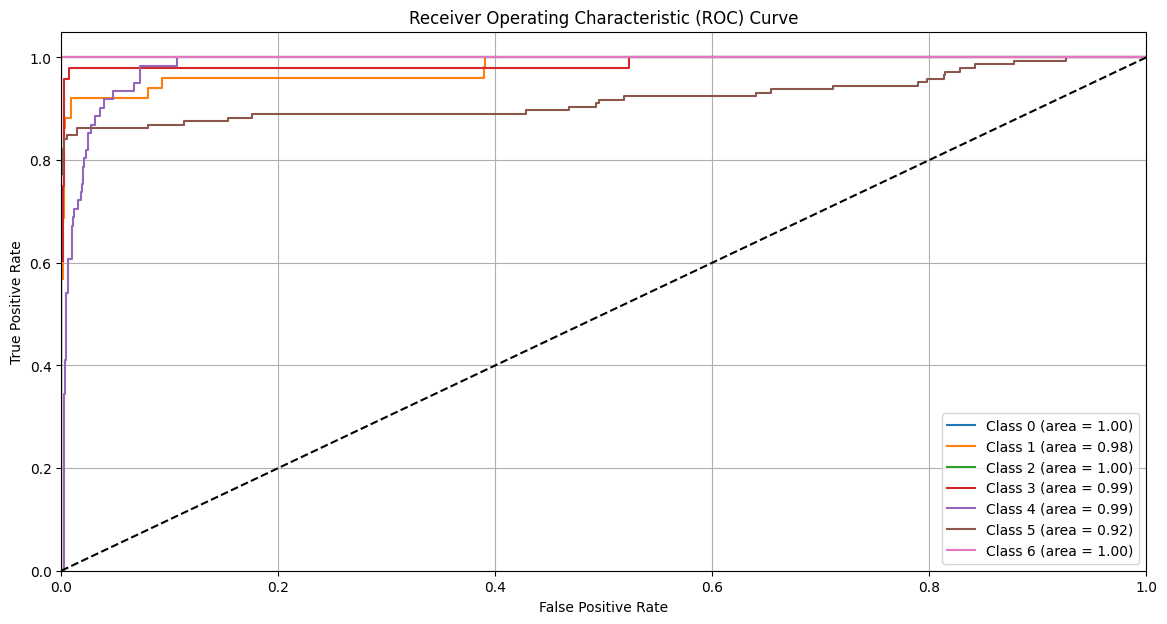

In [ ]:
# Generating and printing the classification report.
print(classification_report(y_true, y_pred, target_names=list(leaves_train_generator.class_indices.keys())))

# Calculating and printing the accuracy and F1 score.
accuracy = accuracy_score(y_true, y_pred)  # Calculating the accuracy score.
f1 = f1_score(y_true, y_pred, average='macro')  # Calculating the macro-averaged F1 score.
print(f'Accuracy: {accuracy:.2f}')  # Printing the accuracy.
print(f'F1 Score: {f1:.2f}')  # Printing the F1 score.

# Generating the ROC curve for each class.
y_pred_proba = leaves_model.predict(leaves_val_generator, steps=leaves_val_generator.n / batch_size)
fpr = {}  # Dictionary to store false positive rates.
tpr = {}  # Dictionary to store true positive rates.
roc_auc = {}  # Dictionary to store area under the curve (AUC) values.
n_classes = len(leaves_train_generator.class_indices)  # Number of classes.

for i in range(n_classes):
    # Calculating the false positive rate, true positive rate, and AUC for each class.
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve for each class.
plt.figure(figsize=(14, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')  # Plotting the ROC curve for each class.
plt.plot([0, 1], [0, 1], 'k--')  # Plotting the diagonal line (random classifier).
plt.xlim([0.0, 1.0])  # Setting the x-axis limits.
plt.ylim([0.0, 1.05])  # Setting the y-axis limits.
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Setting the title of the plot.
plt.xlabel('False Positive Rate')  # Setting the label for the x-axis.
plt.ylabel('True Positive Rate')  # Setting the label for the y-axis.
plt.legend(loc='lower right')  # Adding a legend to the plot.
plt.grid(True)  # Adding a grid to the plot.
plt.show()  # Displaying the plot.


In [ ]:
leaves_model.save('InceptionResNetV2-Based-Leaf-Classification-Model____.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!cp -r InceptionResNetV2-Based-Leaf-Classification-Model____.h5 drive/MyDrive/